In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
import statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import boxcox

In [2]:
df = pd.read_excel('datasets/kuiper.xls')

df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [3]:
df = df.drop(['Make', 'Model', 'Trim', 'Type', 'Doors', 'Sound', 'Leather'], axis=1)

df.head()

,Price,Mileage,Cylinder,Liter,Cruise
0,17314.103129,8221,6,3.1,1
1,17542.036083,9135,6,3.1,1
2,16218.847862,13196,6,3.1,1
3,16336.913140,16342,6,3.1,1
4,16339.170324,19832,6,3.1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Cylinder  804 non-null    int64  
 3   Liter     804 non-null    float64
 4   Cruise    804 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 31.5 KB


## a.	Провести корреляционный анализ имеющихся данных 

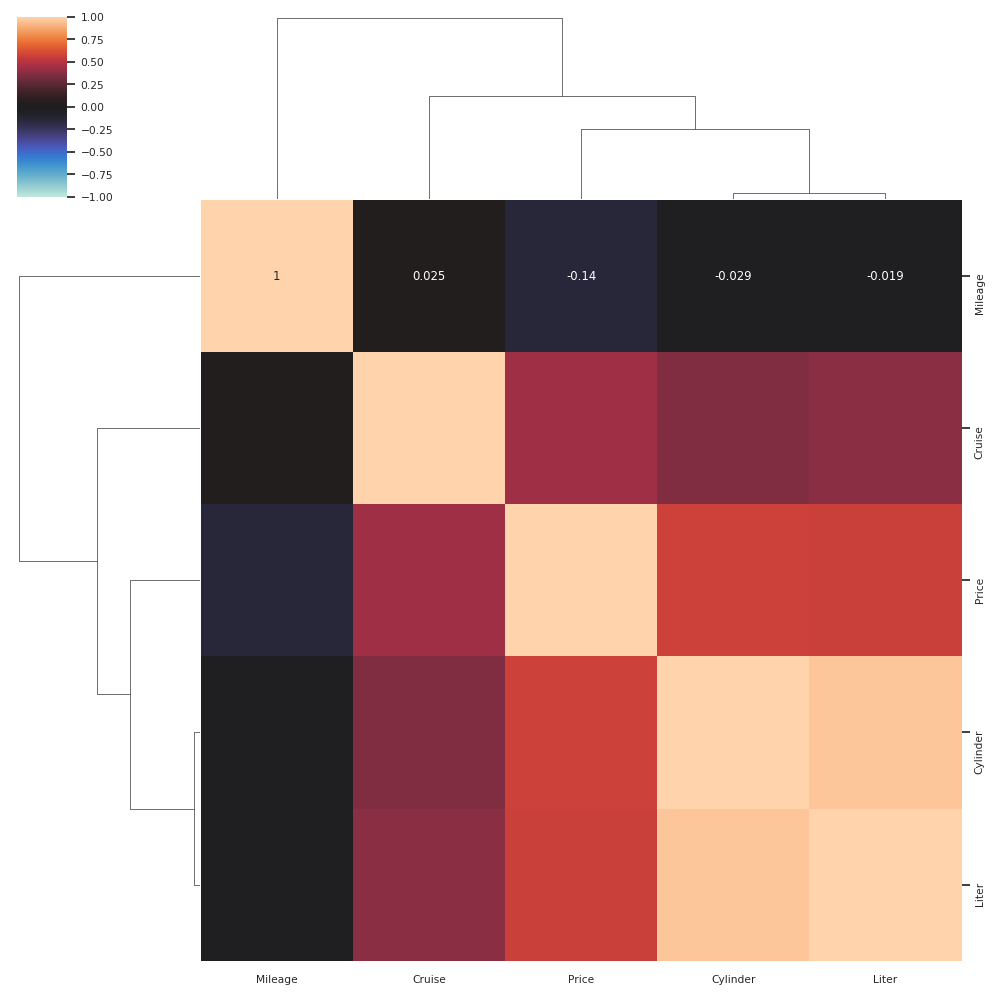

In [5]:
sns.set (font_scale=0.7)
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df)

## b.	Построить базовую модель линейной регрессии.

In [6]:
target = 'Price'
features = list(df.columns)
features.remove(target)

X = df[features]
y = df[[target]]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.32042233115284424

## c.	Вывести результаты анализа базовой модели.

In [7]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     115.5
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           4.76e-74
Time:                        12:23:50   Log-Likelihood:                -6659.2
No. Observations:                 643   AIC:                         1.333e+04
Df Residuals:                     638   BIC:                         1.335e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2032.5013   1711.098      1.188      0.2

## f.	Проверить значимость построенного уравнения регрессии с помощью F-test. 

In [9]:
f_test = est2.f_test("x1 = x2 = x3 = x4 = 0")
if f_test.pvalue < 0.05:
    result = 'Построение уравнения регрессии значимо в целом'
else:
    result = 'Построение уравнения НЕ регрессии значимо в целом'
print(f'F-test: {result:>21s}')
print(f_test.pvalue)

F-test: Построение уравнения регрессии значимо в целом
4.7600301848084895e-74


## g.	Построить график рассеяния и уравнения регрессии.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

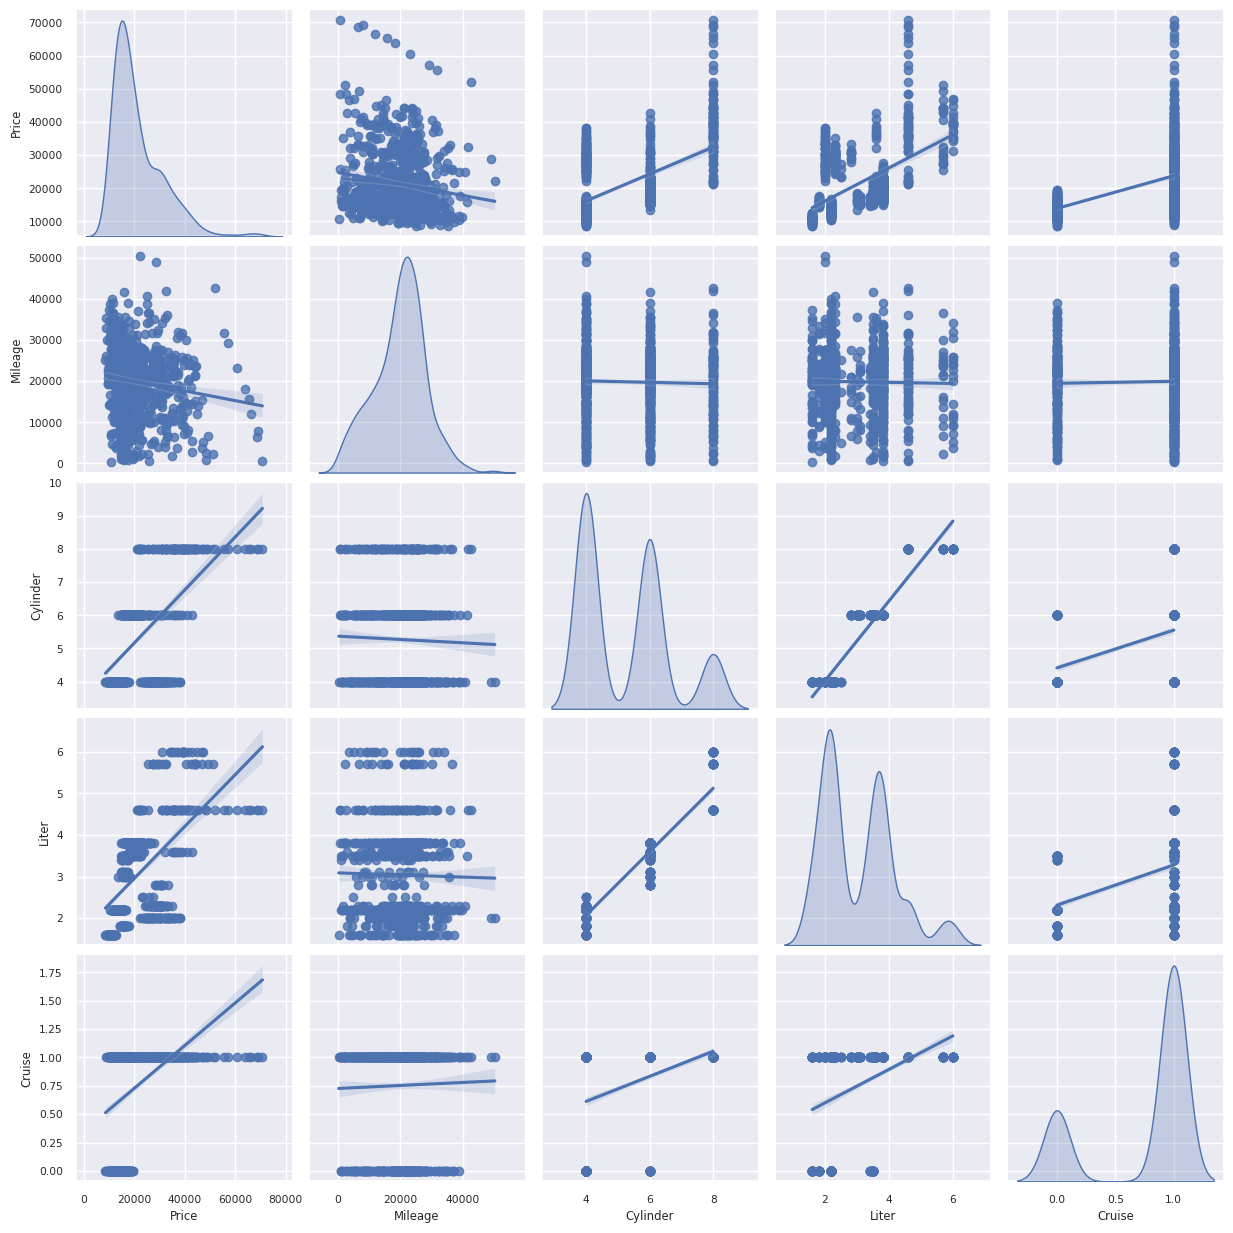

In [10]:
sns.pairplot(df, kind='reg', markers='o', diag_kind='kde', height=2.5);
plt.show()

## i.	В случае подозрения на наличие выбросов, проверить так называемые важные наблюдения, которые значительно влияют на построение модели. 

In [11]:
influence = OLSInfluence(est2)
influence = influence.results.get_influence()
influence.summary_frame()

,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.015127,-0.009750,-0.012343,0.009860,-0.011989,0.000251,-0.691475,0.002618,-0.035430,-0.691192,-0.035415
1,0.079894,-0.040017,-0.057006,0.036044,0.053405,0.002466,1.479360,0.005602,0.111036,1.480742,0.111140
2,-0.008374,0.007673,0.018091,-0.023148,-0.013510,0.000554,-0.989331,0.002825,-0.052654,-0.989315,-0.052653
3,-0.104416,0.000022,0.110054,-0.083767,0.003860,0.004044,1.320307,0.011468,0.142205,1.321078,0.142288
4,-0.000257,-0.002670,-0.007760,0.008855,0.009437,0.000057,-0.174819,0.009215,-0.016859,-0.174686,-0.016846
...,...,...,...,...,...,...,...,...,...,...,...
638,0.010455,-0.003073,-0.010246,0.008214,-0.010470,0.000170,-0.589450,0.002447,-0.029195,-0.589149,-0.029180
639,0.025124,-0.064469,0.014608,-0.020908,-0.010259,0.001392,-1.003477,0.006864,-0.083422,-1.003483,-0.083423
640,0.040796,-0.045839,-0.004266,-0.010804,0.038523,0.001188,0.918601,0.006989,0.077063,0.918488,0.077054
641,-0.008753,0.014569,0.008026,-0.009919,-0.006096,0.000134,-0.406269,0.004047,-0.025898,-0.406003,-0.025881


## j.	Используя функцию Step или StepAIC, постараться улучшить модель. 

In [12]:
def forward_selection(X, y):
    selected_features = []
    remaining_features = set(X.columns)
    best_aic = np.inf

    while remaining_features:
        aic_values = []
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            aic = model.aic
            aic_values.append((feature, aic))

        best_feature, best_aic_candidate = min(aic_values, key=lambda x: x[1])

        if best_aic_candidate < best_aic:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_aic = best_aic_candidate
        else:
            break

    return selected_features            
            

In [13]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("prev AIC: ", est2.aic)

new_features = forward_selection(X, y)
new_X = df[new_features]

X2 = sm.add_constant(new_X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("new AIC: ", est2.aic)

prev AIC:  16668.08256919354
new AIC:  16666.36470072272


## k.	В случае получения в предыдущем пункте модели, отличной от базовой, повторить пп. c-i для новой модели.

In [14]:
X = df[new_features]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.38865732541308984

In [15]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     144.7
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.57e-71
Time:                        12:24:39   Log-Likelihood:                -6671.9
No. Observations:                 643   AIC:                         1.335e+04
Df Residuals:                     639   BIC:                         1.337e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1717.4880   1449.498      1.185      0.2

In [17]:
f_test = est2.f_test("x1 = x2 = x3 = 0")
if f_test.pvalue < 0.05:
    result = 'Построение уравнения регрессии значимо в целом'
else:
    result = 'Построение уравнения НЕ регрессии значимо в целом'
print(f'F-test: {result:>21s}')
print(f_test.pvalue)

F-test: Построение уравнения регрессии значимо в целом
1.5666906219427441e-71


## l.	Построить графики: scatterplot, "Residuals vs Fitted", "Normal Q-Q" , "Residuals vs Leverage" и дать интерпретации. 

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

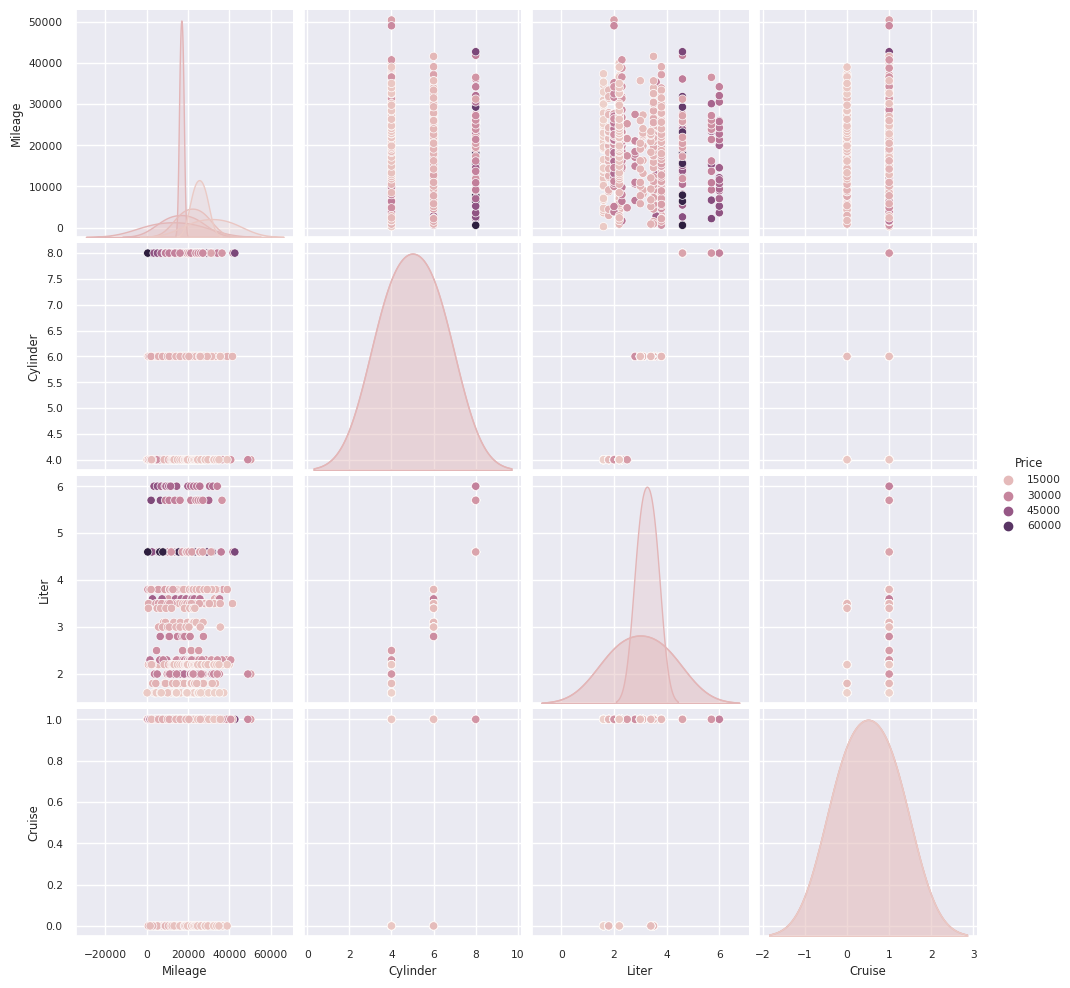

In [18]:
sns.pairplot(df, diag_kind='kde', markers='o', hue='Price');
plt.show()

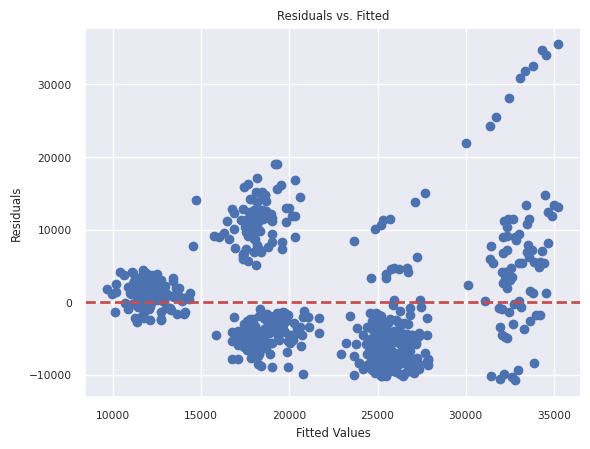

In [19]:
model = sm.OLS(y_train, X_train).fit()

residuals = model.resid
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

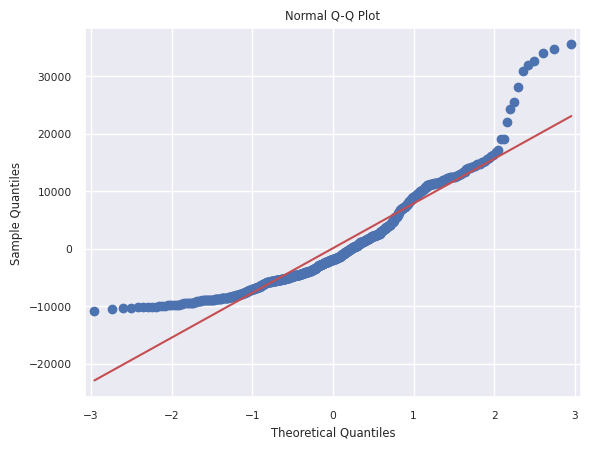

In [20]:
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot')
plt.show()

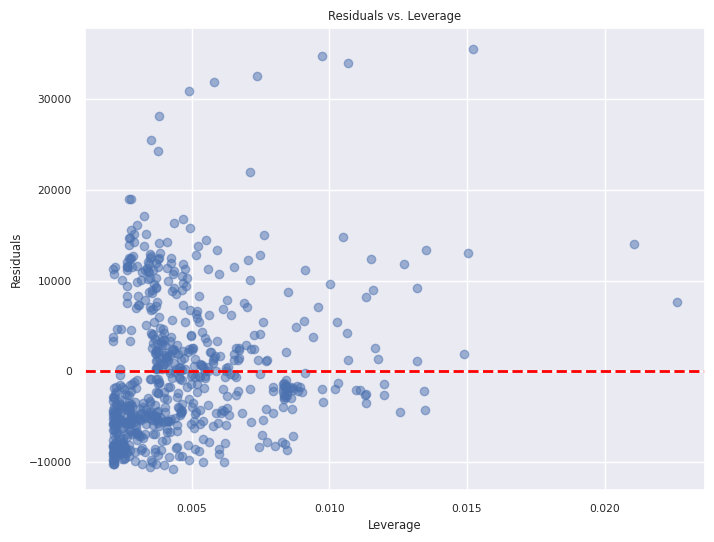

In [21]:
leverage = OLSInfluence(model).hat_matrix_diag

plt.figure(figsize=(8, 6))
plt.scatter(leverage, residuals, alpha=0.5)
plt.title('Residuals vs. Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

## m.	Проверить модель на наличие выбросов. 

In [22]:
model = sm.OLS(y, X).fit()

outlier_test_result = model.outlier_test()

print(outlier_test_result)

     student_resid   unadj_p  bonf(p)
0        -1.260775  0.207757      1.0
1        -1.215029  0.224714      1.0
2        -1.317827  0.187939      1.0
3        -1.247995  0.212398      1.0
4        -1.187614  0.235338      1.0
..             ...       ...      ...
799      -1.227680  0.219928      1.0
800      -1.221634  0.222206      1.0
801      -1.255954  0.209499      1.0
802      -1.241905  0.214636      1.0
803      -1.277861  0.201669      1.0

[804 rows x 3 columns]


## n.	Проверить модель на гетероскедастичность.

In [23]:
# mod_sm = sm.OLS(y, X)
# res_sm = mod_sm.fit()

# bp_lm, bp_lm_pvalue, bp_fvalue, bp_f_pvalue = sm.stats.diagnostic.het_breuschpagan(res_sm.resid, res_sm.model.exog)

name = ['F statistic', 'p-value']
test = statsmodels.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
result = dict(zip(name, test))

print(result)

# if bp_lm_pvalue < 0.05:
#     print("Heteroscedasticity detected")
# else:
#     print("No heteroscedasticity detected")
# print("Breusch-Pagan test p-value:", bp_lm_pvalue)

{'F statistic': 1.2163031991599051, 'p-value': 0.02541396076217734}


## o.	Проверить остатки модели на автокорреляцию.

In [24]:
durbin_watson_statistic = durbin_watson(residuals)

if durbin_watson_statistic < 2:
    result = 'negative autocorrelation'
else:
    result = 'negative autocorrelation'
print(f'Durbin-Watson test: {result:>21s}')
print(durbin_watson_statistic)

Durbin-Watson test: negative autocorrelation
1.897349272765751


## p.	Проверить остатки модели на нормальность распределения. 

In [25]:
jarque_bera_stat, p_value, skewness, kurtosis = sm.stats.jarque_bera(residuals)

if p_value < 0.05:
    result = 'normal distribution'
else:
    result = 'NOT normal distribution'
print(f'Jarque-Bera test: {result:>21s}')
print(kurtosis)

print("Jarque-Bera statistic:", jarque_bera_stat)

Jarque-Bera test:   normal distribution
5.256583611431515
Jarque-Bera statistic: 311.4206930232256


## q.	Проверить модель на мультиколлинеарность данных.

In [26]:
def calculate_vif(data_frame):
    variables = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [sm.OLS(data_frame[variable],
                              sm.add_constant(data_frame.loc[:, data_frame.columns != variable])).fit().rsquared
                      for variable in variables]
    return vif_data

vif_results = calculate_vif(df[new_features])
print(vif_results)

   Variable       VIF
0  Cylinder  0.126988
1    Cruise  0.126777
2   Mileage  0.002307


## r.	Попробовать применить трансформацию Box-Cox зависимой переменной.

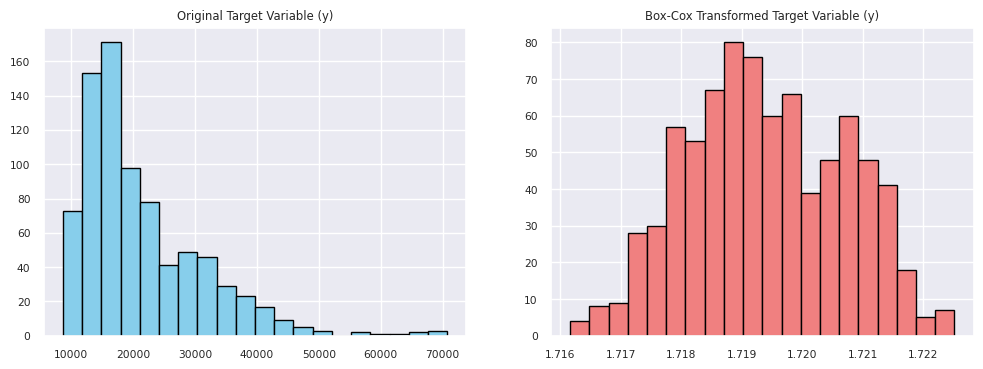

Optimal lambda for transformation of target variable y: -0.5796506493112101


In [27]:
y = df['Price']
transformed_y, lambda_y = boxcox(y + 1) 
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=20, edgecolor='black', color='skyblue')
plt.title('Original Target Variable (y)')

plt.subplot(1, 2, 2)
plt.hist(transformed_y, bins=20, edgecolor='black', color='lightcoral')
plt.title('Box-Cox Transformed Target Variable (y)')

plt.show()

print(f'Optimal lambda for transformation of target variable y: {lambda_y}')

## s.	В случае получения новой модели в предыдущем пункте проанализировать новую модель.

In [28]:
X = df[new_features]

X_train, X_test, y_train, y_test = train_test_split(X.values, transformed_y.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.4883859912888785

In [29]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     183.0
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.28e-85
Time:                        12:25:13   Log-Likelihood:                 3570.3
No. Observations:                 643   AIC:                            -7133.
Df Residuals:                     639   BIC:                            -7115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7169      0.000   9740.920      0.0

In [31]:
f_test = est2.f_test("x1 = x2 = x3 = 0")
if f_test.pvalue < 0.05:
    result = 'Построение уравнения регрессии значимо в целом'
else:
    result = 'Построение уравнения НЕ регрессии значимо в целом'
print(f'F-test: {result:>21s}')
print(f_test.pvalue)

F-test: Построение уравнения регрессии значимо в целом
1.2776011849026708e-85


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

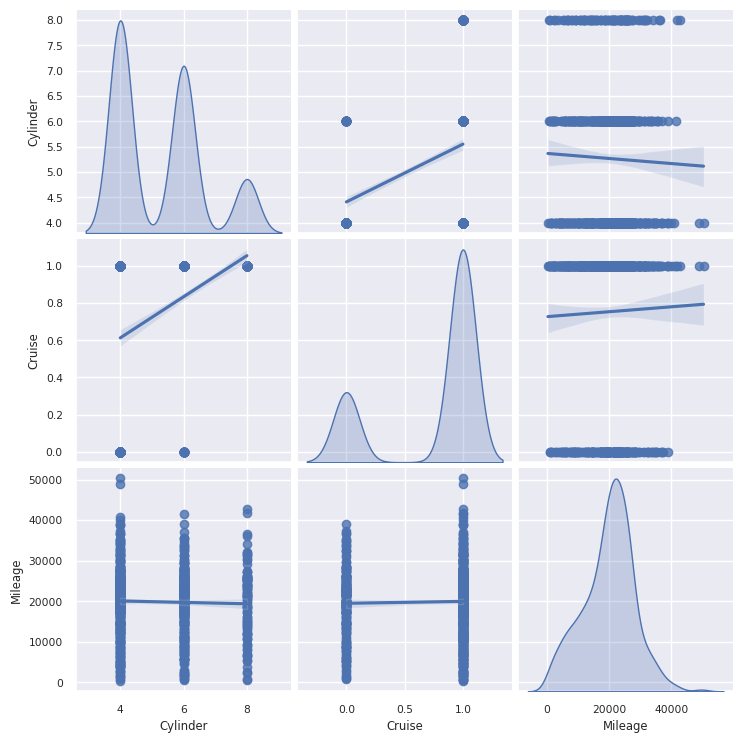

In [32]:
sns.pairplot(df[new_features], kind='reg', markers='o', diag_kind='kde', height=2.5)
plt.show()

In [33]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("prev AIC: ", est2.aic)

new_features = forward_selection(X, y)
new_X = df[new_features]

X2 = sm.add_constant(new_X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("new AIC: ", est2.aic)

prev AIC:  16666.36470072272
new AIC:  16666.36470072272


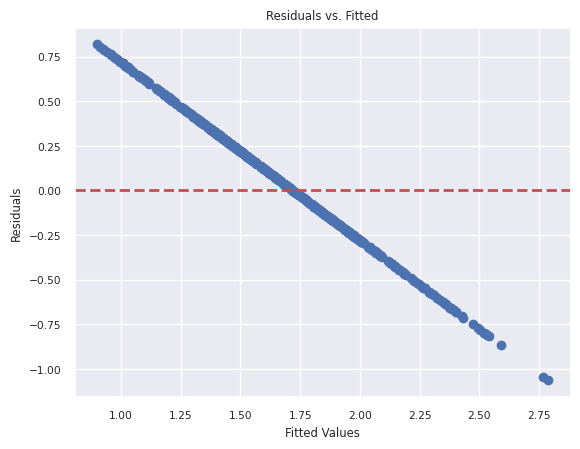

In [34]:
model = sm.OLS(y_train, X_train).fit()

residuals = model.resid
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

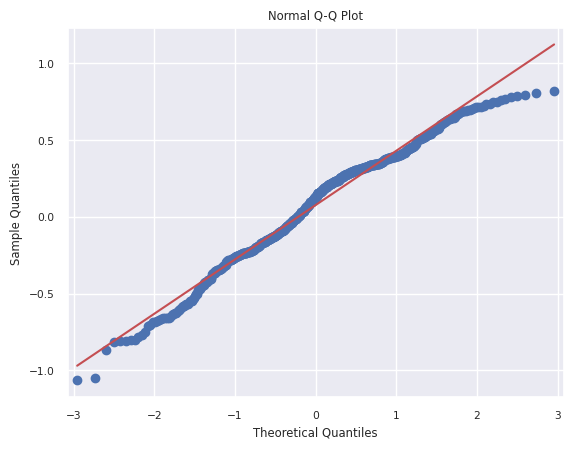

In [35]:
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot')
plt.show()

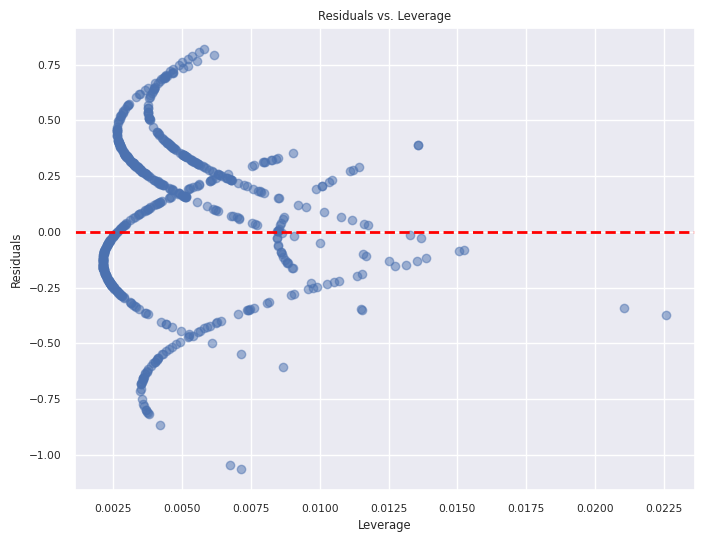

In [36]:
leverage = OLSInfluence(model).hat_matrix_diag

plt.figure(figsize=(8, 6))
plt.scatter(leverage, residuals, alpha=0.5)
plt.title('Residuals vs. Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

In [37]:
model = sm.OLS(y, X).fit()

outlier_test_result = model.outlier_test()

print(outlier_test_result)

     student_resid   unadj_p  bonf(p)
0        -1.260775  0.207757      1.0
1        -1.215029  0.224714      1.0
2        -1.317827  0.187939      1.0
3        -1.247995  0.212398      1.0
4        -1.187614  0.235338      1.0
..             ...       ...      ...
799      -1.227680  0.219928      1.0
800      -1.221634  0.222206      1.0
801      -1.255954  0.209499      1.0
802      -1.241905  0.214636      1.0
803      -1.277861  0.201669      1.0

[804 rows x 3 columns]


In [38]:
a, p_value, b, c = het_breuschpagan(model.resid, X)

if p_value < 0.05:
    result = 'дисперсии остатков различны'
else:
    result = 'дисперсии остатков одинаковы'
print("Breusch-Pagan test p-value:", p_value)
print(result)

ValueError: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

In [ ]:
durbin_watson_statistic = durbin_watson(residuals)

if durbin_watson_statistic < 2:
    result = 'negative autocorrelation'
else:
    result = 'negative autocorrelation'
print(f'Durbin-Watson test: {result:>21s}')
print(durbin_watson_statistic)

Durbin-Watson test: negative autocorrelation
2.0305542500137297


In [ ]:
jarque_bera_stat, p_value, skewness, kurtosis = sm.stats.jarque_bera(residuals)

if p_value < 0.05:
    result = 'normal distribution'
else:
    result = 'NOT normal distribution'
print(f'Jarque-Bera test: {result:>21s}')
print(p_value)

Jarque-Bera test:   normal distribution
2.0803131694479166e-179
Jarque-Bera statistic: 822.8604264026395


In [ ]:
def calculate_vif(data_frame):
    variables = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [sm.OLS(data_frame[variable],
                              sm.add_constant(data_frame.loc[:, data_frame.columns != variable])).fit().rsquared
                      for variable in variables]
    return vif_data

vif_results = calculate_vif(df[new_features])
print(vif_results)

            Variable       VIF
0             Engine  0.663891
1               Year  0.218324
2   Seating Capacity  0.521212
3         Drivetrain  0.616241
4              Owner  0.035822
5              Width  0.647053
6             Height  0.609676
7          Kilometer  0.121909
8          Fuel Type  0.294474
9              Color  0.126933
10      Transmission  0.417108
